In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from daart.data import DataGenerator
from daart.eval import get_precision_recall
from daart.models import HardSegmenter
from daart.transforms import ZScore

### define data paths

In [2]:
expt_id = '2019_06_26_fly2'

base_dir = '/media/mattw/fly/behavior'
# DLC markers
markers_file = os.path.join(base_dir, 'labels', expt_id + '_labeled.h5')
# heuristic labels
labels_file = os.path.join(
    base_dir, 'segmentation', 'states-v3', expt_id + '_beh-states-heuristic.pkl')
# hand labels
hand_labels_file = os.path.join(
    base_dir, 'labels_deepethogram', 'DATA', expt_id, expt_id + '_labels.csv')
# where model results will be saved
model_save_path = '/media/mattw/fly/behavior/daart-demo'

### build data generator

In [3]:
# define data generator signals
signals = ['markers', 'labels']
transforms = [ZScore(), None]
paths = [markers_file, labels_file]
device = 'cuda'  # 'cpu' | 'cuda'

trial_splits = {
    'train_tr': 9,
    'val_tr': 1,
    'test_tr': 0,
    'gap_tr': 0
}

# build data generator
data_gen = DataGenerator(
    [expt_id], [signals], [transforms], [paths], device=device, batch_size=500, 
    trial_splits=trial_splits)
print(data_gen)

Generator contains 1 SingleDataset objects:
2019_06_26_fly2
    signals: ['markers', 'labels']
    transforms: OrderedDict([('markers', ZScore()), ('labels', None)])
    paths: OrderedDict([('markers', '/media/mattw/fly/behavior/labels/2019_06_26_fly2_labeled.h5'), ('labels', '/media/mattw/fly/behavior/segmentation/states-v3/2019_06_26_fly2_beh-states-heuristic.pkl')])



In [4]:
# see what data generator returns
data, dataset = data_gen.next_batch('train')
print(data['batch_idx'])
print(data['markers'].shape)
print(data['labels'].shape)

tensor([1], device='cuda:0')
torch.Size([1, 500, 16])
torch.Size([1, 500])


### build model

In [5]:
# define model params
hparams = {
    'model_type': 'temporal-mlp',
    'input_size': 16,  # dimensionality of markers
    'output_size': 5,  # number of classes
    'n_hid_layers': 1,  # hidden layers in network
    'n_hid_units': 32,  # hidden units per hidden layer
    'n_lags': 16,  # width of temporal convolution window
    'activation': 'relu',  # layer nonlinearity
}

# build model
model = HardSegmenter(hparams)
model.to(device)
print(model)


TemporalMLP architecture
------------------------
    0: Conv1d(16, 32, kernel_size=(33,), stride=(1,), padding=(16,))
    1: ReLU()
    2: Linear(in_features=32, out_features=5, bias=True)



### train model

In [6]:
# define training params
train_kwargs = {
    'learning_rate': 1e-4,  # adam learning rate
    'l2_reg': 0,  # general l2 reg on parameters
    'min_epochs': 1,  # minimum number of training epochs
    'max_epochs': 100,  # maximum number of training epochs
    'val_check_interval': 1,  # requency with which to log performance on val data
    'rng_seed_train': 0,  # control order in which data are served to model
    'enable_early_stop': False,  # True to use early stopping; False will use max_epochs
    'early_stop_history': 10,  # epochs over which to average early stopping metric
    'save_last_model': True,  # true to save out last (as well as best) model
}

# fit model!
model.fit(data_gen, save_path=model_save_path, **train_kwargs)

 73%|███████▎  | 59/81 [00:00<00:00, 578.74it/s]

epoch 000/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 001/100


 52%|█████▏    | 42/81 [00:00<00:00, 414.55it/s]

epoch 002/100


 48%|████▊     | 39/81 [00:00<00:00, 385.15it/s]

epoch 003/100


 64%|██████▍   | 52/81 [00:00<00:00, 516.03it/s]

epoch 004/100


 40%|███▉      | 32/81 [00:00<00:00, 316.64it/s]

epoch 005/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 006/100
epoch 007/100


 38%|███▊      | 31/81 [00:00<00:00, 305.46it/s]

epoch 008/100


100%|██████████| 81/81 [00:00<00:00, 408.95it/s]

epoch 009/100



  0%|          | 0/81 [00:00<?, ?it/s]

epoch 010/100
epoch 011/100


 43%|████▎     | 35/81 [00:00<00:00, 349.55it/s]

epoch 012/100


 51%|█████     | 41/81 [00:00<00:00, 407.14it/s]

epoch 013/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 014/100
epoch 015/100


 40%|███▉      | 32/81 [00:00<00:00, 315.10it/s]

epoch 016/100


 47%|████▋     | 38/81 [00:00<00:00, 375.63it/s]

epoch 017/100


100%|██████████| 81/81 [00:00<00:00, 410.51it/s]

epoch 018/100



 44%|████▍     | 36/81 [00:00<00:00, 354.86it/s]

epoch 019/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 020/100
epoch 021/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 022/100
epoch 023/100


 42%|████▏     | 34/81 [00:00<00:00, 335.48it/s]

epoch 024/100


 37%|███▋      | 30/81 [00:00<00:00, 290.63it/s]

epoch 025/100


 43%|████▎     | 35/81 [00:00<00:00, 343.06it/s]

epoch 026/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 027/100
epoch 028/100


 52%|█████▏    | 42/81 [00:00<00:00, 412.40it/s]

epoch 029/100


 31%|███       | 25/81 [00:00<00:00, 245.95it/s]

epoch 030/100


 48%|████▊     | 39/81 [00:00<00:00, 389.38it/s]

epoch 031/100


 51%|█████     | 41/81 [00:00<00:00, 406.49it/s]

epoch 032/100


 48%|████▊     | 39/81 [00:00<00:00, 381.01it/s]

epoch 033/100


 44%|████▍     | 36/81 [00:00<00:00, 351.11it/s]

epoch 034/100


100%|██████████| 81/81 [00:00<00:00, 419.81it/s]


epoch 035/100
epoch 036/100


 42%|████▏     | 34/81 [00:00<00:00, 339.17it/s]

epoch 037/100


 49%|████▉     | 40/81 [00:00<00:00, 398.00it/s]

epoch 038/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 039/100
epoch 040/100


 44%|████▍     | 36/81 [00:00<00:00, 355.12it/s]

epoch 041/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 042/100
epoch 043/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 044/100
epoch 045/100


 58%|█████▊    | 47/81 [00:00<00:00, 466.02it/s]

epoch 046/100


 58%|█████▊    | 47/81 [00:00<00:00, 467.55it/s]

epoch 047/100


 43%|████▎     | 35/81 [00:00<00:00, 348.86it/s]

epoch 048/100


 33%|███▎      | 27/81 [00:00<00:00, 266.28it/s]

epoch 049/100


 44%|████▍     | 36/81 [00:00<00:00, 356.47it/s]

epoch 050/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 051/100
epoch 052/100


 47%|████▋     | 38/81 [00:00<00:00, 378.71it/s]

epoch 053/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 054/100
epoch 055/100


 36%|███▌      | 29/81 [00:00<00:00, 282.90it/s]

epoch 056/100


 43%|████▎     | 35/81 [00:00<00:00, 348.25it/s]

epoch 057/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 058/100
epoch 059/100


 62%|██████▏   | 50/81 [00:00<00:00, 490.36it/s]

epoch 060/100


 51%|█████     | 41/81 [00:00<00:00, 406.87it/s]

epoch 061/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 062/100
epoch 063/100


 51%|█████     | 41/81 [00:00<00:00, 409.89it/s]

epoch 064/100


 62%|██████▏   | 50/81 [00:00<00:00, 498.16it/s]

epoch 065/100


 52%|█████▏    | 42/81 [00:00<00:00, 415.78it/s]

epoch 066/100


 51%|█████     | 41/81 [00:00<00:00, 403.64it/s]

epoch 067/100


100%|██████████| 81/81 [00:00<00:00, 410.40it/s]

epoch 068/100



 44%|████▍     | 36/81 [00:00<00:00, 357.48it/s]

epoch 069/100


 44%|████▍     | 36/81 [00:00<00:00, 359.81it/s]

epoch 070/100


 62%|██████▏   | 50/81 [00:00<00:00, 490.71it/s]

epoch 071/100


 35%|███▍      | 28/81 [00:00<00:00, 274.57it/s]

epoch 072/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 073/100
epoch 074/100


 49%|████▉     | 40/81 [00:00<00:00, 397.29it/s]

epoch 075/100


 46%|████▌     | 37/81 [00:00<00:00, 362.54it/s]

epoch 076/100


 41%|████      | 33/81 [00:00<00:00, 329.41it/s]

epoch 077/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 078/100
epoch 079/100


 54%|█████▍    | 44/81 [00:00<00:00, 432.59it/s]

epoch 080/100


 38%|███▊      | 31/81 [00:00<00:00, 301.52it/s]

epoch 081/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 082/100
epoch 083/100


100%|██████████| 81/81 [00:00<00:00, 406.80it/s]

epoch 084/100



 51%|█████     | 41/81 [00:00<00:00, 404.79it/s]

epoch 085/100


 54%|█████▍    | 44/81 [00:00<00:00, 433.40it/s]

epoch 086/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 087/100
epoch 088/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 089/100
epoch 090/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 091/100
epoch 092/100


 62%|██████▏   | 50/81 [00:00<00:00, 499.34it/s]

epoch 093/100


 41%|████      | 33/81 [00:00<00:00, 326.36it/s]

epoch 094/100


  0%|          | 0/81 [00:00<?, ?it/s]

epoch 095/100
epoch 096/100


 48%|████▊     | 39/81 [00:00<00:00, 382.64it/s]

epoch 097/100


 52%|█████▏    | 42/81 [00:00<00:00, 413.42it/s]

epoch 098/100


 41%|████      | 33/81 [00:00<00:00, 325.94it/s]

epoch 099/100


 33%|███▎      | 27/81 [00:00<00:00, 267.03it/s]

epoch 100/100


100%|██████████| 81/81 [00:00<00:00, 312.25it/s]


### evaluate model

In [7]:
# load hand labels
from numpy import genfromtxt
labels = genfromtxt(hand_labels_file, delimiter=',', dtype=np.int, encoding=None)
labels = labels[1:, 1:]  # get rid of headers, etc.
states = np.argmax(labels, axis=1)

# get model predictions for each time point
predictions = model.predict_labels(data_gen)['predictions']

# compute precision and recall for each behavior type
scores = get_precision_recall(
    states, np.argmax(np.vstack(predictions[0]), axis=1), background=0)

In [10]:
import pickle
with open(labels_file, 'rb') as f:
    states_heur = pickle.load(f)['states']
    
scores = get_precision_recall(states, states_heur, background=0)

### plot results

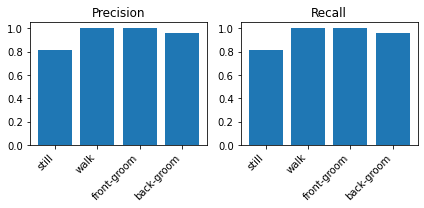

In [11]:
class_names = ['still', 'walk', 'front-groom', 'back-groom']
n_classes = len(class_names)

# get rid of background class
precision = scores['precision'][1:]
recall = scores['recall'][1:]

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].bar(np.arange(n_classes), precision)
axes[0].set_xticks(np.arange(n_classes))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_title('Precision')

axes[1].bar(np.arange(n_classes), precision)
axes[1].set_xticks(np.arange(n_classes))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_title('Recall')

plt.tight_layout()
plt.show()